# Purpose
This notebook serves as an exploratory analysis of new metrics created in this project. The primary metrics used are differentials, which measure the difference in the rate of techniques used between a fighter and his opponent. For instance, if fighter A lands 50 strikes-per-minute, and fighter B lands 30 strikes-per-minute, fighter A has a strikes-per-minute-differential (S/PM-Di) of 20, and fighter B would be rated at -20.
#### Limitations
This metric rates low accuracy strikers with great defense as being equal to high accuracy fighters with poor defense, beacuse the rate gets lower with every punch the fighter recieves.

#### Example case
As a case study for these metrics we are going to compare Khabib Nurmagomedov with Conor McGregor. Khabib is considered one of the best wrestlers of all time, while Conor is considered to be one of the best strikers of all time. In their matchup, Conor was unable to effectively use his striking against Khabib, and Khabib took him down repeatedly before submitting him. We want to see if our new metrics capture the nature of this performance better than the metrics commonly used in Mixed Martial Arts today.

In [9]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
from sqlalchemy import create_engine
from src import local
from src import functions
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Grappling Stats import
Here we import our grappling stats data, this has advanced statistics on reversals, submission attempts, and guard passes for every round in the UFC. We also import our ground strikes and takedown stats, which measure how many strikes are landed on the ground and how many takedowns an opponent lands. Each row in this data set is a single round in the UFC.

In [2]:
grappling = pd.read_csv('../../data/ufcstats_data/advanced_stats/grappling_stats.csv')
ground_strikes = pd.read_csv('../../data/ufcstats_data/advanced_stats/ground_ss_stats.csv')
takedowns = pd.read_csv('../../data/ufcstats_data/advanced_stats/takedown_stats.csv')
grappling.head()

,round,bout_link,fighter_link,rev_p1m,rev_p15m,pass_p1m,pass_p15m,sub_att_p1m,sub_att_p15m,rev_pr_di,rev_p1m_di,rev_p15m_di,pass_pr_di,pass_p1m_di,pass_p15m_di,sub_att_pr_di,sub_att_p1m_di,sub_att_p15m_di
0,1,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
1,2,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,0.0,0.0,0.2,3.0,0.0,0.0,0,0.0,0.0,1,0.2,3.0,0,0.0,0.0
2,3,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
3,4,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
4,5,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0


#### In order to get name and date information, we need to merge these dataframes with our bouts and fighters tables. 

The sql engine uses info in the local.py file. If you are running into an error with this cell, it may be because your local.py file contains incorrect data or is nonexistant. The data from this file should match up to the data on your local postgres database, you may have to set a password in postgres for this to work.

In [3]:
# Credentials
USER = local.user 
PASS = local.password
HOST = local.host
PORT = local.port
#create engine
engine = create_engine(f'postgresql://{USER}:{PASS}@{HOST}:{PORT}/match_finder')

query = """
SELECT name, link
FROM fighters
"""

fighters = pd.read_sql(query, engine)

fighters.head()

,name,link
0,Fabiano Scherner,http://www.ufcstats.com/fighter-details/0bc7e6...
1,Alexandre Dantas,http://www.ufcstats.com/fighter-details/8dc46e...
2,Kevin Burns,http://www.ufcstats.com/fighter-details/a6d8bf...
3,Joseph Sandoval,http://www.ufcstats.com/fighter-details/696002...
4,Jose Aldo,http://www.ufcstats.com/fighter-details/d0f395...


In [4]:
query = """
SELECT "Date" as date, bouts.link
FROM bouts
JOIN events on events.link = bouts.event_link
"""
bouts = pd.read_sql(query, engine)

bouts.head()

,date,link
0,"July 25, 2020",http://www.ufcstats.com/fight-details/11f715fa...
1,"July 25, 2020",http://www.ufcstats.com/fight-details/11f715fa...
2,"July 25, 2020",http://www.ufcstats.com/fight-details/11f715fa...
3,"July 25, 2020",http://www.ufcstats.com/fight-details/11f715fa...
4,"July 25, 2020",http://www.ufcstats.com/fight-details/11f715fa...


Each fighter name can be linked to the stat tables using the unique fighter_link identifier. Then all dates will be connected via the bout_link identifier

In [5]:
grappling = grappling.join(fighters.set_index('link'), on='fighter_link')
ground_strikes = ground_strikes.join(fighters.set_index('link'), on='fighter_link')
takedowns = takedowns.join(fighters.set_index('link'), on='fighter_link')

In [6]:
grappling = grappling.join(bouts.set_index('link'), on='bout_link')
ground_strikes = ground_strikes.join(bouts.set_index('link'), on='bout_link')
takedowns = takedowns.join(bouts.set_index('link'), on='bout_link')

#### We have some rows with missing names, we remove them here

In [7]:
grappling.dropna(subset=['name'], inplace=True, axis=0)
ground_strikes.dropna(subset=['name'], inplace=True, axis=0)
takedowns.dropna(subset=['name'], inplace=True, axis=0)

#### Removing fighters with less than 3 fights

In [8]:
# calculate number of bouts for each fighter
bouts_by_name = pd.DataFrame(takedowns.groupby(['bout_link', 'fighter_link']).name.max())
number_of_bouts = bouts_by_name.groupby('name').name.count()

# subset only the fighters who have had at least 3 bouts
experienced_fighters = list(number_of_bouts[number_of_bouts>=3].index)

# Remove inexperienced fighters
mask = takedowns['name'].isin(experienced_fighters)
takedowns = takedowns[mask]

mask = ground_strikes['name'].isin(experienced_fighters)
ground_strikes = ground_strikes[mask]

mask = grappling['name'].isin(experienced_fighters)
grappling = grappling[mask]

### Measuring Takedown performance
We can easily get the career averages by grouping a column by the fighters name and getting the average for whatever stat we want. First we'll look at the the Takedown Successes Differential per 15 Minutes, which is denoted as td_s_p15m_di in our table. This is a measure of how many more takedowns a fighter landed than their opponent for each 15 minutes they've fought in the UFC. 

#### Here is a function that generates bar graphs comparing two fighters stats.

In [12]:
def compare_stat(stat_df, 
                 stat, 
                 fighter_1='Conor McGregor', 
                 fighter_2='Khabib Nurmagomedov', 
                 graphic_des=False, 
                 fighter_1_offset=.1, 
                 fighter_2_offset=.1):
    """
    input: stat_df -  one of the advanced statistics dataframes with a name column joined
            stat - the stat used for comparison
            fighter_1 and fighter_2 - the names of the fighters being compared
            graphic_des - if True, generates a cleaner image used for reports
            fighter_1_offset and fighter_2_offset - debugging parameters, use if
                                                    numbers are misaligned on
                                                    bar graph
    
    output: returns nothing, displays a matplotlib bar graph
    """
    # getting min and max values for y dimensions, median used for formatting
    min_stat_rating = (stat_df.groupby('name')[stat].mean()).describe()['min']
    max_stat_rating = (stat_df.groupby('name')[stat].mean()).describe()['max']
    median_stat_rating = (stat_df.groupby('name')[stat].mean()).describe()['50%']

    #### Calculate stats for each fighter
    fighter_2_stat = stat_df[stat_df['name']==fighter_2][stat].mean()
    fighter_1_stat = stat_df[stat_df['name']==fighter_1][stat].mean()

    # if the fighters score is below the median, the bar graph turns red
    # and the number is flipped to the bottom of the graph
    if fighter_1_stat>median_stat_rating:
        fighter_1_pos = 'bottom'
        fighter_1_col = 'tab:blue'
    else:
        fighter_1_pos = 'top'
        fighter_1_col = 'tab:red'
    if fighter_2_stat>median_stat_rating:
        fighter_2_pos = 'bottom'
        fighter_2_col = 'tab:blue'
    else:
        fighter_2_pos = 'top'
        fighter_2_col = 'tab:red'
        
    
    # graph
    fig, ax = plt.subplots(1,1, figsize=(5, 10))
    # set dimensions
    ax.set_ylim(min_stat_rating, max_stat_rating)
    # label columns with stat score
    ax.text(x=-0.125, y=fighter_1_stat-fighter_1_offset, 
            s=str(round(fighter_1_stat, 2)), 
            ha='center', 
            va=fighter_1_pos, 
            fontsize=35)
    ax.text(x=0.125, y=fighter_2_stat-fighter_2_offset, 
            s=str(round(fighter_2_stat, 2)), 
            ha='center', 
            va=fighter_2_pos, 
            fontsize=35)
    
    # yticks give context for scale
    plt.yticks([median_stat_rating, max_stat_rating, min_stat_rating], labels=['Average\nRating', 'Best\nRating', 'Worst\nRating'], fontsize=25)
    
    # graph stats
    ax.bar(x=[-0.125], height=[fighter_1_stat], bottom=median_stat_rating, color=fighter_1_col, width=.2)
    ax.bar(x=[.125], height=[fighter_2_stat], bottom=median_stat_rating, color=fighter_2_col, width=.2)
    
    if graphic_des:
        #### Here's a minimalist graph for graphic design use
        # hide ticks
        ax.tick_params(
            axis='both',
            which='both',
            bottom=False,
            top=False,
            labelbottom=False)
        #export image
        plt.tight_layout()
        plt.savefig('../../report/figures/con_kha_'+stat+'.png', transparent=True)
    else:
        ax.set_ylabel(stat)
        plt.xticks([-.125,.125], labels=['\n'.join(fighter_1.split(' ')), '\n'.join(fighter_2.split(' '))], fontsize=25)

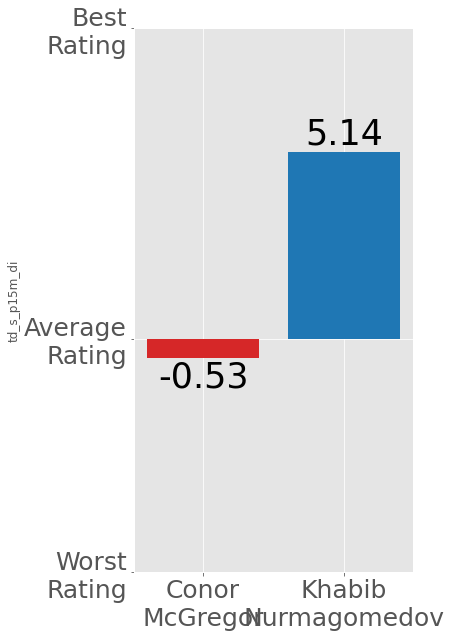

In [13]:
compare_stat(takedowns, 'td_s_p15m_di', graphic_des=False, fighter_1_offset=.3, fighter_2_offset=.2)

#### Khabib has a significantly higher takedown differential, representing his grappling advantage over Conor.

### Ground Strike performance

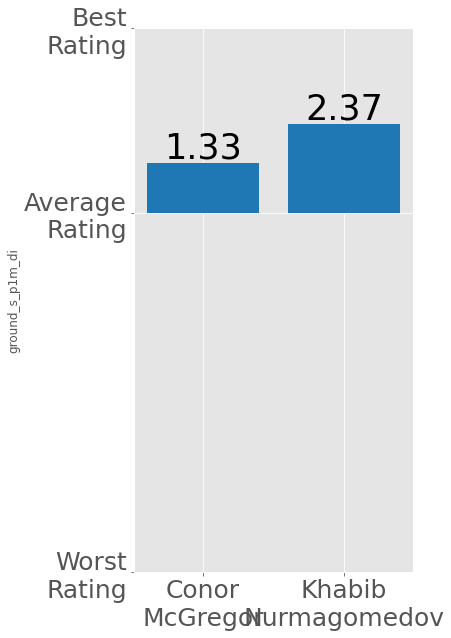

In [14]:
compare_stat(ground_strikes, 'ground_s_p1m_di', graphic_des=False, fighter_1_offset=.1, fighter_2_offset=.1)

#### At this scale, this measure does not appear to show that Khabib is known for ground and pound.
this could be due to Conor's tko's counting as ground strikes.

### Submission performance

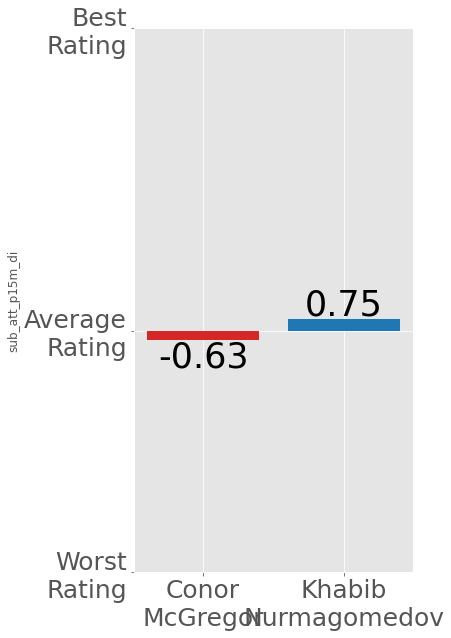

In [15]:
compare_stat(grappling, 'sub_att_p15m_di', graphic_des=False, fighter_1_offset=0, fighter_2_offset=.2)

#### It's important to note that this is submission 'attempts' per minute and does not include successful submissions. Khabib has rarely been in the position to be submitted, but Conor was submitted by Nate Diaz. One thing it does not show is that Khabib has won 3 of his fights by submission, so sub attempts does not seem to be a strong stylistic indicator

## Striking Stats
Here we will look at strikes from a distance and knockdown differentials to see if they show how well-rounded Khabib is and how skilled Conor is.

In [16]:
distance_ss_stats = pd.read_csv('../../data/ufcstats_data/advanced_stats/distance_ss_stats.csv')
knockdown_stats = pd.read_csv('../../data/ufcstats_data/advanced_stats/knockdown_stats.csv')

Each fighter name can be linked to the stat tables using the unique fighter_link identifier. Then all dates will be connected via the bout_link identifier

In [17]:
distance_ss_stats

,round,bout_link,fighter_link,distance_a_p1m,distance_s_p1m,distance_a_p15m,distance_s_p15m,distance_ac,distance_de,distance_s_pr_di,distance_a_pr_di,distance_s_p1m_di,distance_a_p1m_di,distance_s_p15m_di,distance_a_p15m_di
0,1,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,5.800000,2.000000,87.000000,30.000000,0.344828,0.666667,4,11,0.800000,2.200000,12.000000,33.000000
1,2,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,4.600000,2.000000,69.000000,30.000000,0.434783,0.750000,7,11,1.400000,2.200000,21.000000,33.000000
2,3,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,6.000000,2.200000,90.000000,33.000000,0.366667,0.750000,6,10,1.200000,2.000000,18.000000,30.000000
3,4,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,6.200000,2.400000,93.000000,36.000000,0.387097,0.625000,6,15,1.200000,3.000000,18.000000,45.000000
4,5,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,5.200000,2.800000,78.000000,42.000000,0.538462,0.476190,3,5,0.600000,1.000000,9.000000,15.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25767,1,http://www.ufcstats.com/fight-details/693e4a0b...,http://www.ufcstats.com/fighter-details/669a3c...,0.600000,0.000000,9.000000,0.000000,0.000000,0.782609,-5,-20,-1.000000,-4.000000,-15.000000,-60.000000
25768,2,http://www.ufcstats.com/fight-details/693e4a0b...,http://www.ufcstats.com/fighter-details/669a3c...,3.037975,0.000000,45.569620,0.000000,0.000000,0.454545,-6,-7,-4.556962,-5.316456,-68.354430,-79.746835
25769,1,http://www.ufcstats.com/fight-details/c6f85419...,http://www.ufcstats.com/fighter-details/a54a35...,3.157895,1.403509,47.368421,21.052632,0.444444,0.466667,-4,-6,-1.403509,-2.105263,-21.052632,-31.578947
25770,1,http://www.ufcstats.com/fight-details/1db8bed8...,http://www.ufcstats.com/fighter-details/911fb2...,0.400000,0.000000,6.000000,0.000000,0.000000,NaN,0,2,0.000000,0.400000,0.000000,6.000000


In [18]:
distance_ss_stats = distance_ss_stats.join(fighters.set_index('link'), on='fighter_link')
knockdown_stats = knockdown_stats.join(fighters.set_index('link'), on='fighter_link')

distance_ss_stats = distance_ss_stats.join(bouts.set_index('link'), on='bout_link')
knockdown_stats = knockdown_stats.join(bouts.set_index('link'), on='bout_link')

#### We have some rows with missing names, we remove them here
distance_ss_stats.dropna(subset=['name'], inplace=True, axis=0)
knockdown_stats.dropna(subset=['name'], inplace=True, axis=0)

#### Removing fighters with less than 3 fights

In [19]:
# calculate number of bouts for each fighter
bouts_by_name = pd.DataFrame(takedowns.groupby(['bout_link', 'fighter_link']).name.max())
number_of_bouts = bouts_by_name.groupby('name').name.count()

# subset only the fighters who have had at least 3 bouts
experienced_fighters = list(number_of_bouts[number_of_bouts>=3].index)

# Remove inexperienced fighters
mask = distance_ss_stats['name'].isin(experienced_fighters)
distance_ss_stats = distance_ss_stats[mask]
mask = knockdown_stats['name'].isin(experienced_fighters)
knockdown_stats = knockdown_stats[mask]

#### Average Knockdowns

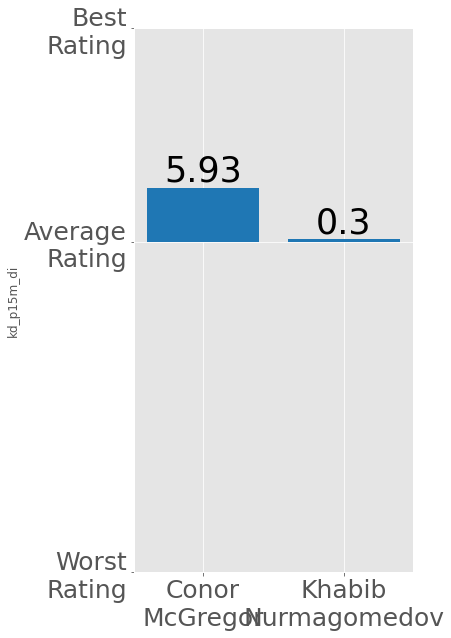

In [20]:
compare_stat(knockdown_stats, 'kd_p15m_di', graphic_des=False)

#### This does show Conor's striking advantage, but not in a very compelling way. Maybe a regular bar graph would do better.

### Strikes at a Distance

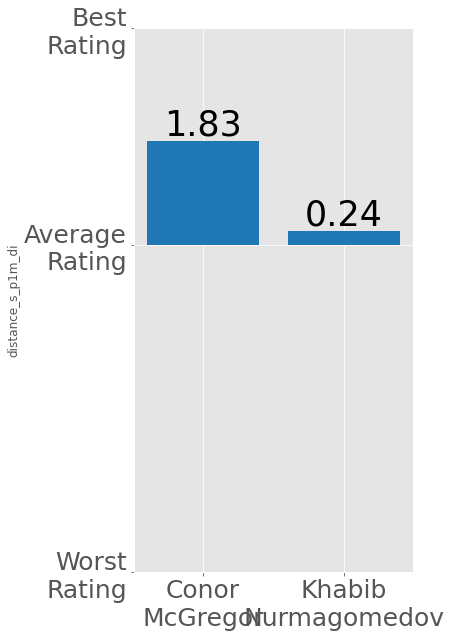

In [21]:
compare_stat(distance_ss_stats, 'distance_s_p1m_di', graphic_des=False)

#### These two differentials do highlight Conor's striking advantage without ignoring the fact that Khabib is still well rounded and possesses better than average striking skills.

### Next Steps
The differentials work well as a metric of fighter tendencies, I will measure their predictive capabilities next. I should also look into better ways of diplaying the metrics, as the graphs used here were difficult to interpret. A regular bargraph starting at the worst rating and changing colors as it gets higher may be more intuitive for an MMA fan looking for quick stats.